In [23]:
import numpy as np
from numpy import linalg as LA
from scipy.linalg import null_space
from ncon import ncon


N = 3
mps = np.random.random(2**N) #+  np.random.random(2**N) * 1j
mps_norm = mps / LA.norm(mps)
psi_norm = mps_norm / LA.norm(mps_norm)
psi = psi_norm.reshape(2,2,2)
print(LA.norm(psi_norm))
print(psi_norm)

mps_sites = [0 for _ in range(N)]
mps_sites_iso = [0 for _ in range(N)]

Atemp, Stemp, Vhtemp = LA.svd(psi.reshape(2,2**(N-1)), full_matrices=False)
mps_sites[0] = Atemp.reshape(1,2,2)  #shape della matrice A_1 ---> A_8 paper è 2,2 - mapping 1 a 1
mps_sites[1] = (np.diag(Stemp)@Vhtemp)/LA.norm(Stemp)

for i in range(1,N-1):
    Atemp, Stemp, Vhtemp = LA.svd(mps_sites[i].reshape(2**2,2**(N-i-1)), full_matrices=False)
    mps_sites[i] = Atemp[:,:2].reshape(2,2,2)
    mps_sites[i+1] = ((np.diag(Stemp[:2])@Vhtemp[:2,:]).reshape(2,-1))/LA.norm(Stemp)

mps_sites[-1] = ((np.diag(Stemp[:2])@Vhtemp[:2,:]).reshape(2,2,1))/LA.norm(Stemp)


print("Checking Isometries:")
for i,site in enumerate(mps_sites):
    print("\n------------\n\nA{} tensor of the MPS".format(i+1))
    print("+ Isometry computed with NCON")
    print(np.round((ncon([site,site],[[1,2,-1],[1,2,-2]]))))
    print("+ Isometry computed with NCON on reshaped tensors")
    print(np.round(ncon([site.reshape(site.shape[0]*site.shape[1], site.shape[2]),
                         site.reshape(site.shape[0]*site.shape[1], site.shape[2])],[[1,-1],[1,-2]])))
    mps_sites_iso[i] = site.reshape(site.shape[0]*site.shape[1], site.shape[2])
    print("+ Isometry check with @ op")
    print("++ Identity A^dagA")
    print(np.round(mps_sites_iso[i].T@mps_sites_iso[i]))
    print("++ Projector AA^dag")
    print(mps_sites_iso[i]@mps_sites_iso[i].T)

print("\n------------\n\n")
print("MPS single tensors shapes = {}".format([i.shape for i in mps_sites]))
print("Single site inds [virt, phys, virt] -> [j, l, k]")
print("MPS matrix form shapes (j,l,k) -> (j*l,k) = {}".format([i.shape for i in mps_sites_iso]))




1.0
[0.37957366 0.47498597 0.14527071 0.52740127 0.24339711 0.08967081
 0.14578906 0.49246221]
Checking Isometries:

------------

A1 tensor of the MPS
+ Isometry computed with NCON
[[ 1. -0.]
 [-0.  1.]]
+ Isometry computed with NCON on reshaped tensors
[[ 1. -0.]
 [-0.  1.]]
+ Isometry check with @ op
++ Identity A^dagA
[[ 1. -0.]
 [-0.  1.]]
++ Projector AA^dag
[[1.00000000e+00 3.87447282e-17]
 [3.87447282e-17 1.00000000e+00]]

------------

A2 tensor of the MPS
+ Isometry computed with NCON
[[1. 0.]
 [0. 1.]]
+ Isometry computed with NCON on reshaped tensors
[[1. 0.]
 [0. 1.]]
+ Isometry check with @ op
++ Identity A^dagA
[[1. 0.]
 [0. 1.]]
++ Projector AA^dag
[[ 0.98310598  0.03810273 -0.11982504 -0.02826226]
 [ 0.03810273  0.87457313  0.30297875 -0.12824597]
 [-0.11982504  0.30297875  0.12299124 -0.04135495]
 [-0.02826226 -0.12824597 -0.04135495  0.01932965]]

------------

A3 tensor of the MPS
+ Isometry computed with NCON
[[1.]]
+ Isometry computed with NCON on reshaped tensors

![Screenshot from 2023-11-10 15-00-15.png](<attachment:Screenshot from 2023-11-10 15-00-15.png>)
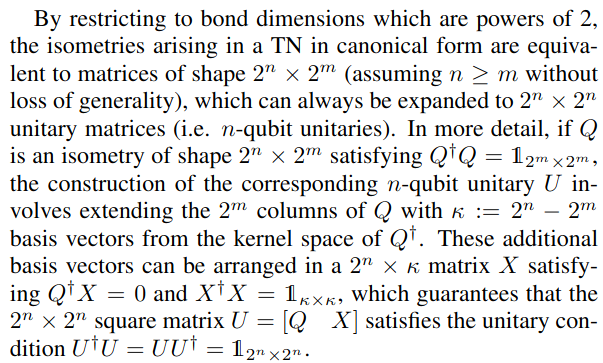

SNIPPET DI CODICE PER L'ESTENSIONE DELLE ISOMETRIE DI DIMENSIONE 2^n x 2^m A MATRICI UNITARIE 2^n x 2^n


In [24]:

print("Creating null_spaces and G matrix [A, X] where X is such that A^dagX = 0 and X^dagX = I\n\n")

G_swap = [0 for _ in range(N)]
kernel = [0 for _ in range(N)]
G = [0 for _ in range(N)]
for i,Q in enumerate(mps_sites_iso):
    print("A{} tensor\n".format(i+1))

    print("+ Tensor:\n{}".format(Q))

    #check isometry
    #assert (np.round(Q.T@Q) - np.eye(Q.shape[1]) == np.zeros((Q.shape[1],Q.shape[1]))).all()

    X = null_space(Q.conjugate().T)
    kernel[i] = X
    print("k = null space vectors: \n{}\n-shape: {}".format(X, X.shape))
    print("Add to Q of shape {}, the matrix X which has shape {}".format(Q.shape, X.shape))

    #check extension shape
    #assert(Q.shape[0] == X.shape[0] and Q.shape[1] + X.shape[1] == Q.shape[0])

    #check orthogonality
    #assert (np.round(Q.conjugate().T@X) == np.zeros((X.shape[1]))).all()

    #check unitarity
    #assert (np.round(X.conjugate().T @ X) == np.eye(X.shape[1])).all()

    #extend the isometry: U = [Q X]
    G[i] = np.block([Q, X])
    print("\nG = [Q X] matrix with shape {}:\n{}".format(G[i].shape, G[i]))
    G_swap[i] = np.block([X, Q])
    print("\nG_swap = [X Q] matrix with shape {}:\n{}".format(G_swap[i].shape, G_swap[i]))

    #check unitarity of G matrix = [Q X] 
    #assert (np.round(G[i].conjugate().T@G[i]) == np.eye(Q.shape[0])).all()
    #assert (np.round(G[i]@G[i].conjugate().T) == np.eye(Q.shape[0])).all()

    #check unitarity of G_swap matrix = [X Q]
    #assert (np.round(G_swap[i].conjugate().T@G_swap[i]) == np.eye(Q.shape[0])).all()
    #assert (np.round(G_swap[i]@G_swap[i].conjugate().T) == np.eye(Q.shape[0])).all()

    print("\n-----------\n")



Creating null_spaces and G matrix [A, X] where X is such that A^dagX = 0 and X^dagX = I


A1 tensor

+ Tensor:
[[-0.82956599 -0.55840869]
 [-0.55840869  0.82956599]]
k = null space vectors: 
[]
-shape: (2, 0)
Add to Q of shape (2, 2), the matrix X which has shape (2, 0)

G = [Q X] matrix with shape (2, 2):
[[-0.82956599 -0.55840869]
 [-0.55840869  0.82956599]]

G_swap = [X Q] matrix with shape (2, 2):
[[-0.82956599 -0.55840869]
 [-0.55840869  0.82956599]]

-----------

A2 tensor

+ Tensor:
[[-0.62158433  0.77248877]
 [-0.75207717 -0.55583546]
 [-0.1807341  -0.30054355]
 [ 0.12388719  0.06310005]]
k = null space vectors: 
[[ 0.12722139  0.02662217]
 [-0.32763728  0.13446444]
 [ 0.93607964  0.02763433]
 [ 0.01494758  0.9901752 ]]
-shape: (4, 2)
Add to Q of shape (4, 2), the matrix X which has shape (4, 2)

G = [Q X] matrix with shape (4, 4):
[[-0.62158433  0.77248877  0.12722139  0.02662217]
 [-0.75207717 -0.55583546 -0.32763728  0.13446444]
 [-0.1807341  -0.30054355  0.93607964  0.02763

CONVERT G OF SHAPE (2,2)(4,4)(4,4) INTO GR4 WITH SHAPE (2,2)(2,2,2,2)(2,2,2,2)

In [28]:

gr4 = [i.reshape(2,2) if i.size ==4 else i.reshape(2,2,2,2) for i in G]
for i in gr4:
    print(i)
    print(i.shape)

gr4_swap = [i.reshape(2,2) if i.size == 4 else i.reshape(2,2,2,2) for i in G_swap]
for i in gr4_swap:
    print(i)
    print(i.shape)

assert (gr4[1][:,:,0,:] == mps_sites[1][:,:,:]).all()
assert (gr4[2][:,:,0,0] == mps_sites[2][:,:,0]).all() #last index is dimension 1 and has only entry 1 (2,2,1)

print("\n\n")
print(gr4_swap[1][:,0,:,:])
print(mps_sites[1][:,:,:])


[[-0.82956599 -0.55840869]
 [-0.55840869  0.82956599]]
(2, 2)
[[[[-0.62158433  0.77248877]
   [ 0.12722139  0.02662217]]

  [[-0.75207717 -0.55583546]
   [-0.32763728  0.13446444]]]


 [[[-0.1807341  -0.30054355]
   [ 0.93607964  0.02763433]]

  [[ 0.12388719  0.06310005]
   [ 0.01494758  0.9901752 ]]]]
(2, 2, 2, 2)
[[[[ 0.43881708 -0.86052981]
   [ 0.23046891 -0.11752492]]

  [[ 0.86052981  0.48533309]
   [ 0.13783918 -0.07028947]]]


 [[[-0.23046891  0.13783918]
   [ 0.96308362  0.01882507]]

  [[ 0.11752492 -0.07028947]
   [ 0.01882507  0.99040037]]]]
(2, 2, 2, 2)
[[-0.82956599 -0.55840869]
 [-0.55840869  0.82956599]]
(2, 2)
[[[[ 0.12722139  0.02662217]
   [-0.62158433  0.77248877]]

  [[-0.32763728  0.13446444]
   [-0.75207717 -0.55583546]]]


 [[[ 0.93607964  0.02763433]
   [-0.1807341  -0.30054355]]

  [[ 0.01494758  0.9901752 ]
   [ 0.12388719  0.06310005]]]]
(2, 2, 2, 2)
[[[[-0.86052981  0.23046891]
   [-0.11752492  0.43881708]]

  [[ 0.48533309  0.13783918]
   [-0.07028947  0.

In [7]:
mps000 = np.zeros((2,2,2))

mps000[0,0,0] = 1.
print(mps000)
assert np.round(LA.norm(mps000),8) == 1.

[[[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]


In [8]:
mpsTrunc = ncon([mps_sites[0], mps_sites[1], mps_sites[2]],[[-1,-2,1],[1,-3,2],[2,-4,-5]])[0,:,:,:,0] #remove the first and last index of size 1 (1,2,2,2,1)-> (2,2,2)
assert np.round(LA.norm(mpsTrunc),8) == 1.

UNITARITY COMPOSITION CHECK


In [13]:
#gr4[0]@gr[0]^dag == gr4[0]^dag@gr4[0] == I2

print("Gr[0]")
print("UU^dag == I2")
UUd = ncon([gr4[0],gr4[0]],[[-1,1],[-2,1]])
print(UUd)
#assert (np.round(UUd) == np.eye(UUd.shape[0])).all()
print("U^dagU == I2")
UdU = ncon([gr4[0],gr4[0]],[[1,-1],[1,-2]])
print(UdU)
#assert (np.round(UdU) == np.eye(UdU.shape[0])).all()

print("\n\n----------\n\n")
print("Gr[1]\n")
print("UU^dag == I4")
#gr4[1]@gr[1]^dag == gr4[1]^dag@gr4[1] == I4
UUd = ncon([gr4[1],gr4[1]],[[1,2,-1,-2],[1,2,-3,-4]])
print(np.round(UUd))
print(np.round(UUd.reshape(4,4)))
#assert (np.round(UUd) == np.eye(UUd.shape[0]**2).reshape(2,2,2,2)).all()
print("U^dagU == I4")
UdU = ncon([gr4[1],gr4[1]],[[-1,-2,1,2],[-3,-4,1,2]])
print(np.round(UdU))
print(np.round(UdU.reshape(4,4)))
#assert (np.round(UdU) == np.eye(UdU.shape[0]**2).reshape(2,2,2,2)).all()


print("\n\n----------\n\n")
print("Gr[2]\n")
print("UU^dag == I4")
#gr4[1]@gr[1]^dag == gr4[1]^dag@gr4[1] == I4
UUd = ncon([gr4[2],gr4[2]],[[1,2,-1,-2],[1,2,-3,-4]])
print(np.round(UUd))
print(np.round(UUd.reshape(4,4)))
#assert (np.round(UUd) == np.eye(UUd.shape[0]**2).reshape(2,2,2,2)).all()
print("U^dagU == I4")
UdU = ncon([gr4[2],gr4[2]],[[-1,-2,1,2],[-3,-4,1,2]])
print(np.round(UdU))
print(np.round(UdU.reshape(4,4)))
#assert (np.round(UdU) == np.eye(UdU.shape[0]**2).reshape(2,2,2,2)).all()

Gr[0]
UU^dag == I2
[[1.00000000e+00 3.30635481e-16]
 [3.30635481e-16 1.00000000e+00]]
U^dagU == I2
[[1.00000000e+00 3.30635481e-16]
 [3.30635481e-16 1.00000000e+00]]


----------


Gr[1]

UU^dag == I4
[[[[ 1. -0.]
   [-0.  0.]]

  [[-0.  1.]
   [-0. -0.]]]


 [[[-0. -0.]
   [ 1.  0.]]

  [[ 0. -0.]
   [ 0.  1.]]]]
[[ 1. -0. -0.  0.]
 [-0.  1. -0. -0.]
 [-0. -0.  1.  0.]
 [ 0. -0.  0.  1.]]
U^dagU == I4
[[[[ 1.  0.]
   [ 0. -0.]]

  [[ 0.  1.]
   [ 0. -0.]]]


 [[[ 0.  0.]
   [ 1. -0.]]

  [[-0. -0.]
   [-0.  1.]]]]
[[ 1.  0.  0. -0.]
 [ 0.  1.  0. -0.]
 [ 0.  0.  1. -0.]
 [-0. -0. -0.  1.]]


----------


Gr[2]

UU^dag == I4
[[[[ 1.  0.]
   [-0.  0.]]

  [[ 0.  1.]
   [ 0. -0.]]]


 [[[-0.  0.]
   [ 1.  0.]]

  [[ 0. -0.]
   [ 0.  1.]]]]
[[ 1.  0. -0.  0.]
 [ 0.  1.  0. -0.]
 [-0.  0.  1.  0.]
 [ 0. -0.  0.  1.]]
U^dagU == I4
[[[[ 1.  0.]
   [-0.  0.]]

  [[ 0.  1.]
   [-0.  0.]]]


 [[[-0. -0.]
   [ 1. -0.]]

  [[ 0.  0.]
   [-0.  1.]]]]
[[ 1.  0. -0.  0.]
 [ 0.  1. -0.  0.]
 [-0. -0.

In [12]:
#gr4_swap[0]@gr[0]^dag == gr4[0]^dag@gr4[0] == I2

print("Gr_swap[0]")
print("UU^dag == I2")
UUd = ncon([gr4_swap[0],gr4_swap[0]],[[-1,1],[-2,1]])
print(UUd)
#assert (np.round(UUd) == np.eye(UUd.shape[0])).all()
print("U^dagU == I2")
UdU = ncon([gr4_swap[0],gr4_swap[0]],[[1,-1],[1,-2]])
print(UdU)
#assert (np.round(UdU) == np.eye(UdU.shape[0])).all()

print("\n\n----------\n\n")
print("Gr_swap[1]\n")
print("UU^dag == I4")
#gr4_swap[1]@gr[1]^dag == gr4_swap[1]^dag@gr4_swap[1] == I4
UUd = ncon([gr4_swap[1],gr4_swap[1]],[[1,2,-1,-2],[1,2,-3,-4]])
print(np.round(UUd))
print(np.round(UUd.reshape(4,4)))
#assert (np.round(UUd) == np.eye(UUd.shape[0]**2).reshape(2,2,2,2)).all()
print("U^dagU == I4")
UdU = ncon([gr4_swap[1],gr4_swap[1]],[[-1,-2,1,2],[-3,-4,1,2]])
print(np.round(UdU))
print(np.round(UdU.reshape(4,4)))
#assert (np.round(UdU) == np.eye(UdU.shape[0]**2).reshape(2,2,2,2)).all()


print("\n\n----------\n\n")
print("Gr_swap[2]\n")
print("UU^dag == I4")
#gr4_swap[1]@gr[1]^dag == gr4_swap[1]^dag@gr4_swap[1] == I4
UUd = ncon([gr4_swap[2],gr4_swap[2]],[[1,2,-1,-2],[1,2,-3,-4]])
print(np.round(UUd))
print(np.round(UUd.reshape(4,4)))
#assert (np.round(UUd) == np.eye(UUd.shape[0]**2).reshape(2,2,2,2)).all()
print("U^dagU == I4")
UdU = ncon([gr4_swap[2],gr4_swap[2]],[[-1,-2,1,2],[-3,-4,1,2]])
print(np.round(UdU))
print(np.round(UdU.reshape(4,4)))
#assert (np.round(UdU) == np.eye(UdU.shape[0]**2).reshape(2,2,2,2)).all()

Gr_swap[0]
UU^dag == I2
[[1.00000000e+00 3.30635481e-16]
 [3.30635481e-16 1.00000000e+00]]
U^dagU == I2
[[1.00000000e+00 3.30635481e-16]
 [3.30635481e-16 1.00000000e+00]]


----------


Gr_swap[1]

UU^dag == I4
[[[[ 1.  0.]
   [-0. -0.]]

  [[ 0.  1.]
   [ 0. -0.]]]


 [[[-0.  0.]
   [ 1. -0.]]

  [[-0. -0.]
   [-0.  1.]]]]
[[ 1.  0. -0. -0.]
 [ 0.  1.  0. -0.]
 [-0.  0.  1. -0.]
 [-0. -0. -0.  1.]]
U^dagU == I4
[[[[ 1.  0.]
   [ 0. -0.]]

  [[ 0.  1.]
   [ 0. -0.]]]


 [[[ 0.  0.]
   [ 1. -0.]]

  [[-0. -0.]
   [-0.  1.]]]]
[[ 1.  0.  0. -0.]
 [ 0.  1.  0. -0.]
 [ 0.  0.  1. -0.]
 [-0. -0. -0.  1.]]


----------


Gr_swap[2]

UU^dag == I4
[[[[ 1.  0.]
   [-0.  0.]]

  [[ 0.  1.]
   [ 0. -0.]]]


 [[[-0.  0.]
   [ 1.  0.]]

  [[ 0. -0.]
   [ 0.  1.]]]]
[[ 1.  0. -0.  0.]
 [ 0.  1.  0. -0.]
 [-0.  0.  1.  0.]
 [ 0. -0.  0.  1.]]
U^dagU == I4
[[[[ 1.  0.]
   [-0.  0.]]

  [[ 0.  1.]
   [-0.  0.]]]


 [[[-0. -0.]
   [ 1. -0.]]

  [[ 0.  0.]
   [-0.  1.]]]]
[[ 1.  0. -0.  0.]
 [ 0.  1. -0.

In [31]:
#check first composition Gr4[1]Gr4[0]
MPO = ncon([gr4[2],gr4[1],gr4[0]],[[1,-4,-1,-2],[2,-5,-3, 1],[2,-6]])   #FUNZIONA  
MPSMPO = ncon([mps000,MPO],[[1,2,3],[3,2,1,-3,-2,-1]])
print("MPS OG: \n{}".format(mpsTrunc))
print("MPO 000 with MPO applied: \n{}".format(MPSMPO))
print(ncon([mpsTrunc, MPSMPO],[[1,2,3],[1,2,3]]))

MPS OG: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
MPO 000 with MPO applied: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
0.9999999999999996


In [ ]:
#SWAP
MPO = ncon([gr4[2],gr4[1],gr4[0]],[[1,-4,-1,-2],[2,-5,-3, 1],[2,-6]])   #FUNZIONA  
MPSMPO = ncon([mps000,MPO],[[1,2,3],[3,2,1,-3,-2,-1]])
print("MPS OG: \n{}".format(mpsTrunc))
print("MPO 000 with MPO applied: \n{}".format(MPSMPO))
print(ncon([mpsTrunc, MPSMPO],[[1,2,3],[1,2,3]]))

MPS OG: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
MPO 000 with MPO applied: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
0.9999999999999996


In [32]:
#REORDERED MPO 

MPO2 = ncon([gr4[2].transpose(3,2,1,0),gr4[1].transpose(3,2,1,0),gr4[0]],[[-1,-2,-4,1],[1,-3,-5, 2],[2,-6]])
MPSMPO2 = ncon([mps000, MPO2],[[3,2,1],[1,2,3,-1,-2,-3]])

print("MPS OG: \n{}".format(mpsTrunc))
print("MPO 000 with MPO2 applied: \n{}".format(MPSMPO))
print(ncon([mpsTrunc, MPSMPO2.T],[[1,2,3],[1,2,3]]))

MPS OG: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
MPO 000 with MPO2 applied: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
0.9999999999999996


In [33]:
print(ncon([mpsTrunc,MPO],[[1,2,3],[-1,-2,-3,3,2,1]]))
print(np.round(ncon([mpsTrunc,MPO],[[1,2,3],[-1,-2,-3,3,2,1]])[0,0,0]))

[[[ 1.00000000e+00 -2.77555756e-17]
  [ 1.38777878e-16  5.55111512e-17]]

 [[ 5.55111512e-17  1.38777878e-17]
  [-1.11022302e-16  9.71445147e-17]]]
1.0


In [ ]:
#REORDERED MPO 

MPO2 = ncon([gr4[2].transpose(3,2,1,0),gr4[1].transpose(3,2,1,0),gr4[0]],[[-1,-2,-4,1],[1,-3,-5, 2],[2,-6]])
MPSMPO2 = ncon([mps000, MPO2],[[3,2,1],[1,2,3,-1,-2,-3]])

print("MPS OG: \n{}".format(mpsTrunc))
print("MPO 000 with MPO2 applied: \n{}".format(MPSMPO))
print(ncon([mpsTrunc, MPSMPO2.T],[[1,2,3],[1,2,3]]))

MPS OG: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
MPO 000 with MPO2 applied: 
[[[0.11760342 0.18309296]
  [0.74344737 0.1980575 ]]

 [[0.20446109 0.50917244]
  [0.05674821 0.23753816]]]
0.9999999999999996
